# Create charts showing F QoC, D QoC, and more
Quality of competition will be TOI/60-based. Also sizes bubbles by TOI/60 and colors by net offensive zone faceoffs on-ice for per 60. (This is customizable.)

### Import

In [1]:
import PbPMethods2 as pm2
import GetPbP
from pylab import *
%matplotlib inline
import pandas as pd

### Generate game-by-game if necessary
It will take awhile. Only do this if you haven't done it before (ever) or if it's the current season and more games have been played since you last updated.

In [2]:
#pm2.gen_gamebygame(2007)

### Set parameters

In [3]:
team = 'WSH' #please only choose one team
seasons = {2014, 2015} #choose as many as you like
seasons = list(seasons)
seasons.sort()
allowed_pos = {'F', 'D'} #Stick to F and/or D for simplicity
min_toi_cutoff = 1000 #in minutes
min_game = 20001 #change to 30111 for playoffs only; can also change to other values
max_game = 21230 #change to 30417 to include playoffs; can also change to other values
save_file = None #change to a path if you wish. Note: figure might get slightly cut off

### Read in data

In [4]:
dfs = []
for season in seasons:
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
dfs.head()

,Player,Team,Pos,Game,Season,Date,TOION(60s),CFON,CAON,TOIOFF(60s),...,NZS,OZS,iG,iCF,iA1,iA2,SACFON,SACAON,SACFOFF,SACAOFF
0,Mike Santorelli,TOR,F,20001,2014,08-Oct-14,0.178056,10,9,0.634444,...,4,5,0,3,0,1,9.440,9.553,32.399,42.783
1,Stuart Percy,TOR,D,20001,2014,08-Oct-14,0.258333,14,15,0.554167,...,7,4,0,2,0,0,13.468,15.635,28.371,36.701
2,Roman Polak,TOR,D,20001,2014,08-Oct-14,0.253333,15,13,0.559167,...,8,5,0,2,0,0,14.463,13.423,27.376,38.913
3,Matt Frattin,TOR,F,20001,2014,08-Oct-14,0.153056,7,6,0.659444,...,4,2,0,1,0,0,6.654,6.262,35.185,46.074
4,Brandon Kozun,TOR,F,20001,2014,08-Oct-14,0.201389,10,14,0.611111,...,4,3,0,1,1,0,9.560,14.612,32.279,37.724


Filter based on parameters above. You can add other filters pretty easily, though instead of using .apply() and lambda functions it may be easier to go with something like
$$filtered = filtered[filtered[var] >= val]$$ where you set $var$ and $val$.

In [5]:
filtered = dfs[dfs['Team'] == team]

filtered = filtered[filtered['Game'].apply(lambda x: min_game <= x <= max_game)]

filtered = filtered[filtered['Pos'].apply(lambda x: x in allowed_pos)]

grouped = filtered.groupby('Player').sum()
grouped.reset_index()

grouped = grouped[grouped['TOION(60s)'].apply(lambda x: x*60 >= min_toi_cutoff)]

grouped['FQoC'] = grouped['FComp'] / grouped['F Faced']
grouped['DQoC'] = grouped['DComp'] / grouped['D Faced']
grouped['FQoT'] = grouped['FTeam'] / grouped['F With']
grouped['DQoT'] = grouped['DTeam'] / grouped['D With']
grouped['OZS/60'] = (grouped['OZS'] - grouped['DZS']) / grouped['TOION(60s)']
grouped['TOI/60'] = 60 * grouped['TOION(60s)']/(grouped['TOION(60s)'] + grouped['TOIOFF(60s)'])
print('Columns available:')
print(grouped.columns)

Columns available:
Index(['Game', 'Season', 'TOION(60s)', 'CFON', 'CAON', 'TOIOFF(60s)', 'CFOFF',
       'CAOFF', 'GFON', 'GAON', 'GFOFF', 'GAOFF', 'FComp', 'DComp', 'FTeam',
       'DTeam', 'F Faced', 'D Faced', 'F With', 'D With', 'DZS', 'NZS', 'OZS',
       'iG', 'iCF', 'iA1', 'iA2', 'SACFON', 'SACAON', 'SACFOFF', 'SACAOFF',
       'FQoC', 'DQoC', 'FQoT', 'DQoT', 'OZS/60', 'TOI/60'],
      dtype='object')


### Plot
You can change the variables you want plotted here. Remember that we've summed--you can manipulate data in other ways in the cell above, either doing your own multiplications and divisions (e.g. grouped['TOI%'] = grouped['TOION(60s)']/(grouped['TOION(60s)'] + grouped['TOIOFF(60s)']) or aggregating another way than .sum() (e.g. .mean() or .max()).

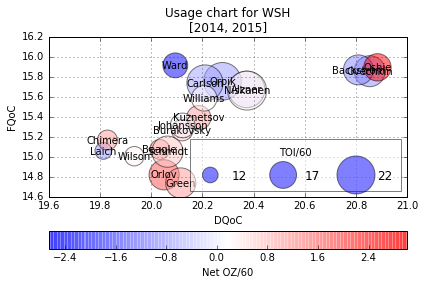

In [6]:
xvar = 'DQoC'
yvar = 'FQoC'
sizevar = 'TOI/60'
colorvar = 'OZS/60'

def size_function(x):
    """exaggerates differences because the difference between 
    areas 12 and 16 visually isn't easy to see
    Redefine based on trial and error as you see fit
    """
    if x <= 5:
        return 0
    return 5 * (x - 5) ** 2

x = grouped[xvar]
y = grouped[yvar]
colors = grouped[colorvar]
sizes = grouped[sizevar].apply(size_function)

scatter(x, y, c=colors, s=sizes, cmap=plt.cm.bwr, alpha=0.5)
cbar = colorbar(orientation='horizontal')
cbar.set_label('Net OZ/60')
xlabel(xvar)
ylabel(yvar)
title('Usage chart for ' + team + '\n' + str(seasons))

for p, xval, yval in zip(grouped.index, x, y):
    annotate(p.split(' ', 1)[1], xy=(xval, yval), ha='center', va='center')

grid(b=True, which='major', axis='y', linestyle=':')
grid(b=True, which='major', axis='x', linestyle=':')

#Create a legend for the sizing
smallest = int(grouped[sizevar].min())
avg = int(grouped[sizevar].mean())
largest = int(grouped[sizevar].max())

l1 = plt.scatter([], [], s=size_function(smallest), edgecolors='k', alpha=0.5)
l2 = plt.scatter([], [], s=size_function(avg), edgecolors='k', alpha=0.5)
l3 = plt.scatter([], [], s=size_function(largest), edgecolors='k', alpha=0.5)
labels = [smallest, avg, largest]
plt.legend([l1, l2, l3], labels, ncol=3, loc=4, labelspacing=1, borderpad=0.7, title='TOI/60', 
           scatterpoints=1, scatteryoffsets=[0.5], framealpha=0.5)

gcf().tight_layout()
if save_file is not None:
    savefig(save_file)